In [1]:
import time
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from joblib import Parallel, delayed, cpu_count

# Modelos de Scikit-Learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

print("✅ Librerías importadas correctamente.")

✅ Librerías importadas correctamente.


In [2]:
def obtener_tareas():
    """Genera una lista nueva de modelos para entrenar."""
    return [
        ("Linear Reg", LinearRegression()),
        ("Ridge", Ridge(alpha=1.0)),
        ("Arbol (D=10)", DecisionTreeRegressor(max_depth=10)),
        # Random Forests: Aquí limitamos profundidad para que no tarde una eternidad
        ("RF (10 est)", RandomForestRegressor(n_estimators=10, max_depth=10)),
        ("RF (20 est)", RandomForestRegressor(n_estimators=20, max_depth=10)), 
        ("RF (50 est)", RandomForestRegressor(n_estimators=50, max_depth=10)),
    ]

def entrenar_evaluar(nombre, model, X_train, y_train, X_test, y_test):
    """
    Función que ejecutará cada núcleo del procesador.
    IMPORTANTE: Forzamos n_jobs=1 para evitar conflicto de hilos.
    """
    if hasattr(model, 'n_jobs'):
        model.set_params(n_jobs=1) 
        
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = r2_score(y_test, pred)
    return (nombre, score)

print("✅ Funciones definidas en memoria.")

✅ Funciones definidas en memoria.


In [3]:
# CONFIGURACIÓN
N_SAMPLES = 250_000  # 250k es un buen equilibrio. 700k tardará más.
N_FEATURES = 15      # Columnas

print(f"--- ⏳ Generando {N_SAMPLES:,} filas de datos... ---")
X, y = make_regression(n_samples=N_SAMPLES, n_features=N_FEATURES, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Datos listos: {X_train.shape} filas de entrenamiento.")

--- ⏳ Generando 250,000 filas de datos... ---
✅ Datos listos: (200000, 15) filas de entrenamiento.


In [4]:
print(f"--- 🐢 Iniciando Ejecución SECUENCIAL ---")
lista_modelos = obtener_tareas()
start_seq = time.time()

# Bucle normal de Python
for nombre, modelo in lista_modelos:
    print(f"   ...Entrenando {nombre}...")
    # En secuencial, permitimos que el modelo use toda la potencia si quiere
    if hasattr(modelo, 'n_jobs'):
        modelo.set_params(n_jobs=-1) 
    
    entrenar_evaluar(nombre, modelo, X_train, y_train, X_test, y_test)

tiempo_seq = time.time() - start_seq
print(f"\n⏱️ Tiempo Secuencial: {tiempo_seq:.4f} segundos")

--- 🐢 Iniciando Ejecución SECUENCIAL ---
   ...Entrenando Linear Reg...
   ...Entrenando Ridge...
   ...Entrenando Arbol (D=10)...
   ...Entrenando RF (10 est)...
   ...Entrenando RF (20 est)...
   ...Entrenando RF (50 est)...

⏱️ Tiempo Secuencial: 189.0823 segundos


In [5]:
n_cores = cpu_count()
print(f"--- 🐇 Iniciando Ejecución PARALELA ({n_cores} núcleos) ---")
lista_modelos = obtener_tareas() # Reiniciamos modelos
start_par = time.time()

# Ejecución en paralelo
# verbose=10 intentará imprimir progreso (revisa la consola negra si no sale aquí)
resultados = Parallel(n_jobs=n_cores, backend='loky', verbose=5)(
    delayed(entrenar_evaluar)(nombre, modelo, X_train, y_train, X_test, y_test) 
    for nombre, modelo in lista_modelos
)

tiempo_par = time.time() - start_par
print(f"\n⏱️ Tiempo Paralelo: {tiempo_par:.4f} segundos")

--- 🐇 Iniciando Ejecución PARALELA (8 núcleos) ---


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   15.0s remaining:   15.0s



⏱️ Tiempo Paralelo: 149.6966 segundos


[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  2.5min finished


In [6]:
print("="*40)
print("📊 INFORME FINAL DE RENDIMIENTO")
print("="*40)
print(f"🐢 Secuencial : {tiempo_seq:.4f} s")
print(f"🐇 Paralelo   : {tiempo_par:.4f} s")

if tiempo_par > 0:
    speedup = tiempo_seq / tiempo_par
    ahorro = tiempo_seq - tiempo_par
    porcentaje = (ahorro / tiempo_seq) * 100
    
    print(f"\n🚀 Speedup: {speedup:.2f}x veces más rápido")
    print(f"📉 Te ahorraste: {ahorro:.2f} segundos ({porcentaje:.1f}%)")
    
    if speedup > 1.2:
        print("✅ CONCLUSIÓN: El paralelismo funcionó correctamente.")
    else:
        print("⚠️ CONCLUSIÓN: La ganancia fue poca (aumenta los datos en Celda 3).")

📊 INFORME FINAL DE RENDIMIENTO
🐢 Secuencial : 189.0823 s
🐇 Paralelo   : 149.6966 s

🚀 Speedup: 1.26x veces más rápido
📉 Te ahorraste: 39.39 segundos (20.8%)
✅ CONCLUSIÓN: El paralelismo funcionó correctamente.


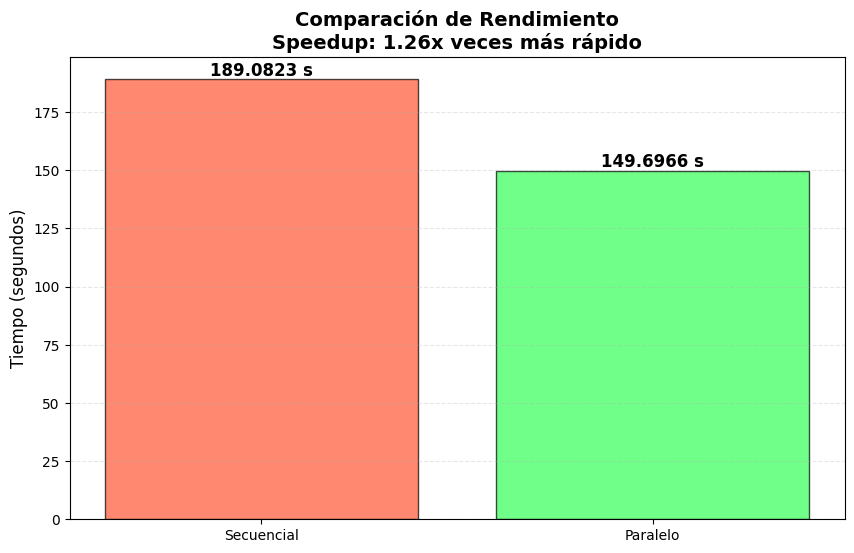

In [7]:
import matplotlib.pyplot as plt

# 1. Preparamos los datos
etiquetas = ['Secuencial', 'Paralelo']
valores = [tiempo_seq, tiempo_par]
colores = ['#FF5733', '#33FF57'] # Rojo para lento, Verde para rápido

# 2. Configuración del gráfico
plt.figure(figsize=(10, 6))
barras = plt.bar(etiquetas, valores, color=colores, alpha=0.7, edgecolor='black')

# 3. Títulos y etiquetas
plt.ylabel('Tiempo (segundos)', fontsize=12)
plt.title(f'Comparación de Rendimiento\nSpeedup: {tiempo_seq/tiempo_par:.2f}x veces más rápido', fontsize=14, fontweight='bold')

# 4. Poner el valor exacto encima de cada barra
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura,
             f'{altura:.4f} s',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# 5. Mostrar
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()